# Logo Detection

In this notebook, we develop a model to locate and lable company logos within static images.

#### Import dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
import detectron2
import cv2
import os
import pathlib
import json
import random
from PIL import Image, ImageDraw2
import pandas as pd
import torchvision
from torchvision import transforms
import torch
import shutil
import glob

In [2]:
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_train_loader, build_detection_test_loader

### Model Training

We need to train our model on some labled data sets. 

#### Load in the training data

In [3]:
def get_dicts(IMG_DIR):
    '''Returns a list of dicts - one for each image
    Each dict contains labels and bounding boxes
    
    Each folder (train, val, test) contains a data.json file
    '''

    path = os.path.join(IMG_DIR, 'data.json')
    dataset_dict = json.load(open(path))
    
    for item in dataset_dict:
        for ann in item['annotations']:
            ann['bbox_mode'] = BoxMode.XYXY_ABS    

    return dataset_dict

In [4]:
def get_metadata(dataset_name):
    metadata = MetadataCatalog.get(dataset_name)

    return metadata        

def sample_plot(dataset_dict, metadata, LOC):
    d = random.sample(dataset_dict, 1)[0]
    img = cv2.imread(os.path.join(LOC, d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [5]:
def register(IMG_DIR, class_names, subfolders=['train', 'test']):
    '''Register datasets for detectron2
    '''
    for d in subfolders:
        DatasetCatalog.register(f"{IMG_DIR}_{d}", lambda d=d: get_dicts(f'{IMG_DIR}/{d}'))
        MetadataCatalog.get(f"{IMG_DIR}_{d}").set(thing_classes=class_names)

In [6]:
logo_train = get_dicts('/Users/sowatson/dev/Summit2020LogoDetection/data/combined/train')

In [7]:
labels = list(pd.read_csv('/Users/sowatson/dev/Summit2020LogoDetection/data/combined/train/labels.csv')['class'].unique())

In [8]:
DatasetCatalog.clear() 
MetadataCatalog._NAME_TO_META = {}
register('/Users/sowatson/dev/Summit2020LogoDetection/data/combined/', labels, ['train', 'test'])

In [9]:
logo_train_metadata = get_metadata('logo_detector/combined_train')

['sas', 'rh', 'anaconda', 'cloudera']


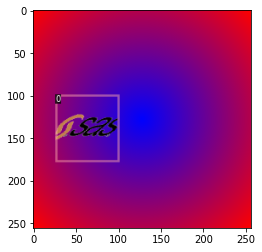

In [10]:
random.seed("summit2020")
sample_plot(logo_train, logo_train_metadata, '/Users/sowatson/dev/Summit2020LogoDetection/data')
print(labels)

#### Train the model

In [11]:
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = N_iter    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes  # 4 classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg 

In [ ]:
N_classes = 4
trainer, cfg = prepare_for_training(10, 
                                    '/Users/sowatson/dev/Summit2020LogoDetection/data/logo_detector_output', 
                                    '/Users/sowatson/dev/Summit2020LogoDetection/data/combined/_train', 
                                    N_classes, 
                                    start_training=True)

## Validating the model

In [ ]:
import inspect
inspect.getfile(torch)

In [ ]:
torch.cuda.is_available()

In [ ]:
trainer_discard, cfg = prepare_for_training(1, 
                                            'logo_detector_output', 
                                            'logo_detector/combined_train', 
                                            4, 
                                            start_training=False)
predictor = prepare_for_inference(cfg, 'logo_detector/combined_test', threshold=0.50)


In [ ]:
predictor.cfg.MODEL.DEVICE = 'cpu'
predictor.model = predictor.model.to('cpu')

In [ ]:
predictor = prepare_for_inference(cfg, 'logo_detector/combined_test', threshold=0.50)

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()

cfg.MODEL.DEVICE

In [ ]:
cfg.MODEL.DEVICE='cpu'

In [ ]:
cfg.MODEL.DEVICE